In [1]:
%matplotlib inline

In [2]:
import os
import sys
import netCDF4
import numpy as np
from geophys_utils import NetCDFPointUtils, get_spatial_ref_from_wkt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from pprint import pprint
#print(sys.version)
#pprint(dict(os.environ))

In [3]:
def rescale_array(input_np_array, new_range_min=0, new_range_max=1):
    old_min = input_np_array.min()
    old_range = input_np_array.max() - old_min
    new_range = new_range_max - new_range_min

    scaled_np_array = ((input_np_array - old_min) / old_range * new_range) + new_range_min

    return scaled_np_array

In [7]:
def plot_survey_points(netcdf_path, variable_to_map, colour_scheme='binary'):

    nc = netCDF4.Dataset(netcdf_path)

    netcdf_point_utils = NetCDFPointUtils(nc)

    utm_wkt, utm_coords = netcdf_point_utils.utm_coords(netcdf_point_utils.xycoords[:])
    
    utm_zone = get_spatial_ref_from_wkt(utm_wkt).GetUTMZone() # -ve for Southern Hemisphere
    southern_hemisphere = (utm_zone < 0)
    utm_zone = abs(utm_zone)
    projection = ccrs.UTM(zone=utm_zone, southern_hemisphere=southern_hemisphere)

    #print(nc.variables)
    variable = nc.variables[variable_to_map][:]

    colour_array = rescale_array(variable, 0, 1)

    #map_image = cimgt.OSM()# http://developer.mapquest.com/web/products/open/map for terms of use
    #map_image = cimgt.StamenTerrain() # http://maps.stamen.com/
    map_image = cimgt.QuadtreeTiles()
    fig = plt.figure(figsize=(30,20))

    ax = fig.add_subplot(1, 1, 1, projection=projection)

    ax.set_title("Point Gravity Survey - " + str(nc.getncattr('title')))

    ax.add_image(map_image, 10)
    
    # set the x and y axis tick values
    x_min = np.min(utm_coords[:,0])
    x_max = np.max(utm_coords[:,0])
    y_min = np.min(utm_coords[:,1])
    y_max = np.max(utm_coords[:,1])

    range_x = x_max - x_min
    range_y = y_max - y_min

    ax.set_xticks([x_min, range_x / 2 + x_min, x_max])
    ax.set_yticks([y_min, range_y / 2 + y_min, y_max])

    # set the x and y axis labels
    ax.set_xlabel("Eastings (m)", rotation=0, labelpad=20)
    ax.set_ylabel("Northings (m)", rotation=90, labelpad=20)
    
    # See link for possible colourmap schemes: https://matplotlib.org/examples/color/colormaps_reference.html
    cm = plt.cm.get_cmap(colour_scheme)
    
    # build a scatter plot of the specified data, define marker, spatial reference system, and the chosen colour map type
    sc = ax.scatter(utm_coords[:,0], 
                    utm_coords[:,1], 
                    marker='o', 
                    c=colour_array, 
                    s=4, 
                    alpha=0.9, 
                    transform=projection, 
                    cmap=cm
                   )

    # set the colour bar ticks and labels
    cb = plt.colorbar(sc, ticks=[0, 1])
    cb.ax.set_yticklabels([str(np.min(variable)), str(np.max(variable))])  # vertically oriented colorbar
    cb.set_label("Free Air Anomaly (um/s^2)")

    plt.show()

In [8]:
nc_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/axi547/ground_gravity/point_datasets/194701.nc'

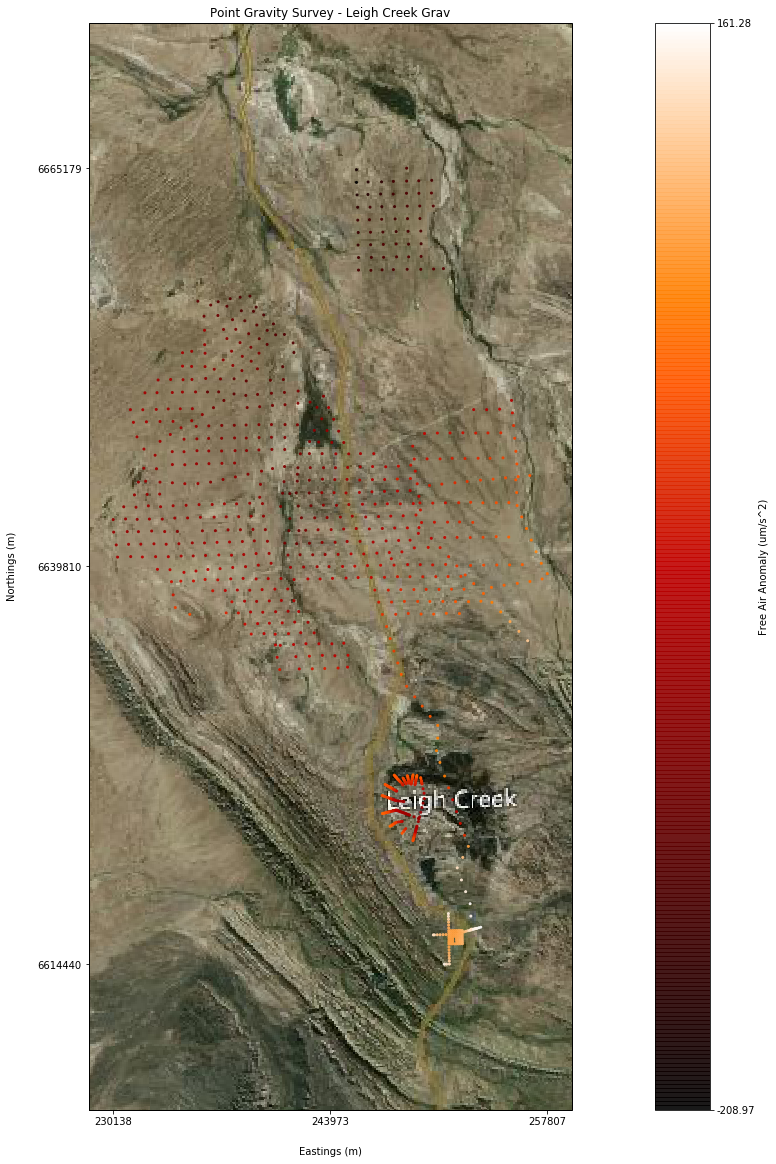

In [9]:
plot_survey_points(nc_path, 'Freeair', 'gist_heat')